In [2]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
#from dataAnalyze import DataAnalyze


In [ ]:
exp1647_eye = pd.read_csv('data/processed/v1/eyetracking/24-08-24-1647_setting0.csv')

with open('data/processed/v1/trial_data/24-08-24-1647_setting0.json', 'r') as file:
    exp1647_log = json.load(file)


## package


In [3]:
class DataAnalyze: 
    def __init__(self,eye_data, log_data, pivot = 'show cue') -> None:
        self.eye_data = eye_data
        self.log_data = pd.DataFrame(log_data)

        self.pivot = pivot
        self.pivot_since_trial_start = 0.0

    def getlog_events_df(self, trial_num):    
        events_data = self.log_data['events'].iloc[trial_num-1]
        events_df = pd.DataFrame(events_data)
        return events_df


    def getlog_t_pivot(self, trial_num):
        events_df = self.getlog_events_df(trial_num)
        pivot_time = events_df[events_df['event'] == self.pivot]['time'].values[0]
        return pivot_time
    
    def geteye_pupil_pivot(self, trial_num, eye_data):
        pivot_time = self.getlog_t_pivot(trial_num)
        #eye_data = self.geteye_data(trial_num)
        for _, row in eye_data.iterrows():
            if row['TimeEvent']> pivot_time:
                pivot_pupil_size = row['Pupil']
                break
        return pivot_pupil_size
            
        
    def getlog_modified_events_df(self, trial_num: int, adjust=True, truncate = True):
        events_df = self.getlog_events_df(trial_num)
        if adjust:
            events_df['adjusted_time'] = events_df['time'] - self.getlog_t_pivot(trial_num) + self.pivot_since_trial_start
        if truncate:
            events_df = events_df.iloc[2:]
        return events_df
    
    
    def geteye_data(self, trial_num:int):
        return self.eye_data[self.eye_data['trial_index'] == trial_num]
    

    def geteye_pupil_data(self, trial_num:int, exclude_EFIX = True, event: str = None, adjust_time = False, normalize = False):
        trial_data = self.geteye_data(trial_num)
        if not exclude_EFIX:
            pupil_data = trial_data[trial_data['Pupil'].notna()]
        else:
            pupil_data = trial_data[(trial_data['Pupil'].notna()) & (trial_data['Start'].isna())]
        
        if event:
            pupil_data = pupil_data[pupil_data['event'] == event]
        
        if adjust_time:
            pupil_data.loc[:, 'adTimeEvent'] = pupil_data['TimeEvent'] - self.getlog_t_pivot(trial_num) + self.pivot_since_trial_start


            #pupil_data.loc[:, f'normalized_{self.pivot}'] = 100*((pupil_data['Pupil'] - pivot_pupil)/pivot_pupil)
        return pupil_data

    def normalize(self, trial_num, pupil_data):
        pivot_pupil = self.geteye_pupil_pivot(trial_num, pupil_data)
        pupil_data['normalized'] = 100 * ((pupil_data['Pupil'] - pivot_pupil) / pivot_pupil)
        return pupil_data

    def geteye_time(self, event:str, trial_list:list):
        time_list = []
        for index in trial_list:
            time = self.eye_data[self.eye_data['Event']==str(event)]['Time'].iloc[index-1]
            time_list.append(time)
        return time_list
    
    def getlog_time(self, event:str, trial_list:list, adjust = False):
        time_list = []
        for trial_num in trial_list:
            events_table = self.getlog_trial_events_table(trial_num)
            time = events_table[events_table['event']==str(event)]['time'].iloc[trial_num-1]
            if adjust:
                time = time - self.getlog_t_pivot_time(trial_num) + self.pivot_since_trial_start
            time_list.append(time)
        return time_list
        
    
    def plot_pupil_size(self, trial_list:list, blink_processed = True, normalized = True):
        plt.figure(figsize=(12, 6))

        for trial_index in trial_list:
            df_events = self.getlog_modified_events_df(trial_index)
            if not blink_processed: 
                df_pupil = self.geteye_pupil_data(trial_index, adjust_time=True)
                df_pupil['Pupil_derivative'] = df_pupil['Pupil'].diff() / df_pupil['adTimeEvent'].diff()
            else:
                df_pupil = self.process_blink(trial_index)
                if normalized:
                    self.normalize(trial_index, df_pupil)



            for _, row in df_pupil.iterrows():
                if row['event'] == 'show fixation':
                    line_color = 'b'
                elif row['event'] == 'show cue':
                    line_color = 'r'
                elif row['event'] == 'start decision window':    
                    line_color = 'g'
                elif row['event'] == 'start sound':
                    line_color = 'y'
                else:
                    line_color = 'k'
                if normalized:
                    plt.plot(row['adTimeEvent'], row['normalized'], marker='o', color=line_color)
                else:
                    plt.plot(row['adTimeEvent'], row['Pupil'], marker='o', color=line_color)

                #plt.hlines(y=row['Pupil'], xmin=row['adStart'], xmax=row['adEnd'], color=line_color, linewidth=2, alpha=0.6)
                
                # plt.text((row['adStart'] + row['adEnd']) / 2, row['Pupil'], row['event'], 
                #               ha='center', va='bottom', fontsize=9)

        plt.xticks(df_events['adjusted_time'], 
                labels=[f"{event}\n{time:.3f}" if (event in ['show cue', 'show fixation', 'start sound', 'start decision window']) & (time > (self.pivot_since_trial_start-1)) else '' 
                        for event, time in zip(df_events['event'], df_events['adjusted_time'])], 
                rotation=45, ha='right')
        plt.title('Pupil Size Over Time with Event Labels')
        plt.xlabel('Adjusted Time')
        plt.ylabel('Pupil Size')
        if not normalized:
            plt.yticks(np.arange(900, 1500, 50))
        plt.grid(True)
        plt.show()


    def categorize(self, column_names:list, dataframe=None):
        if dataframe is None:
            dataframe = self.log_data.copy(deep=True)
        grouped_log = dataframe.groupby(column_names)
        keys = []
        for key in grouped_log.groups:
            keys.append(key)
        return grouped_log, keys



    def plot_pupil_size_drv(self, trial_list: list, blink_processed = False):
        fig, ax1 = plt.subplots(figsize=(12, 6))

        for trial_index in trial_list:
            df_events = self.getlog_modified_events_df(trial_index)
            if not blink_processed: 
                df_pupil = self.geteye_pupil_data(trial_index, adjust_time=True)
                df_pupil['Pupil_derivative'] = df_pupil['Pupil'].diff() / df_pupil['adTimeEvent'].diff()
            else:
                df_pupil = self.process_blink(trial_index)

            # Plot the original pupil size on the left y-axis
            for _, row in df_pupil.iterrows():
                if row['event'] == 'show fixation':
                    line_color = 'b'
                elif row['event'] == 'show cue':
                    line_color = 'r'
                elif row['event'] == 'start decision window':    
                    line_color = 'g'
                elif row['event'] == 'start sound':
                    line_color = 'y'
                else:
                    line_color = 'k'
                ax1.plot(row['adTimeEvent'], row['Pupil'], marker='o', color=line_color)

      
            # Compute the second derivative (rate of change of the rate of change) of pupil size
            #df_pupil['Pupil_second_derivative'] = df_pupil['Pupil_derivative'].diff() / df_pupil['adTimeEvent'].diff()

            # Event labels for the x-axis
            ax1.set_xticks(df_events['adjusted_time'])
            ax1.set_xticklabels([f"{event}\n{time:.3f}" if (event in ['show cue', 'show fixation', 'start sound', 'start decision window']) & 
                                (time > (self.pivot_since_trial_start-1)) else '' 
                                for event, time in zip(df_events['event'], df_events['adjusted_time'])], 
                                rotation=45, ha='right')

            # Left axis labels
            ax1.set_title('Pupil Size and Derivatives Over Time with Event Labels')
            ax1.set_xlabel('Adjusted Time')
            ax1.set_ylabel('Pupil Size')
            ax1.grid(True)

        # Create a second y-axis for the first and second derivatives
        ax2 = ax1.twinx()
        
        # Plot the first derivative on the right y-axis
        ax2.plot(df_pupil['adTimeEvent'], df_pupil['Pupil_derivative'], label='First Derivative', color='orange', linestyle='--')
        
        # Plot the second derivative on the right y-axis
        #ax2.plot(df_pupil['adTimeEvent'], df_pupil['Pupil_second_derivative'], label='Second Derivative', color='purple', linestyle=':')

        
        # Right axis labels
        ax2.set_ylabel('First and Second Derivative')
        
        # Adding legends for both y-axes
        ax1.legend(['Pupil Size'], loc='upper left')
        #ax2.legend(['First Derivative', 'Second Derivative'], loc='upper right')
        ax2.legend(['First Derivative'], loc='upper right')

        plt.show()


    def geteye_blink_interval(self, trial_num):
        pupil_data = self.geteye_data(trial_num)
        blink_data = pupil_data[pupil_data['Type'] == 'Blink']
        blink_intervals = []
        process_intervals = []
        # early_reference_intervals = [] 
        # late_reference_intervals = []
        reference_intervals = []
        for _, row in blink_data.iterrows():
            start, end = row['Start'], row['End']
            blink_intervals.append([start,end])
            process_intervals.append([start-0.15,end+0.15])
            reference_intervals.append([[start-0.2,start-0.15], [end+0.15,end+0.2]])
            #100points
            # early_reference_intervals.append([start-0.15, start-0.10])
            # late_reference_intervals.append([end+0.1, end+0.15])

        return blink_intervals, process_intervals, reference_intervals
    
    

    def find_refered_rows(self, df_pupil, reference_intervals):
        # Get pupil data
        #df_pupil = self.geteye_pupil_data(trial_index, adjust_time=True)
        
        # Get process and reference intervals (assuming these are the correct intervals)
        #_, _, reference_intervals = self.geteye_blink_interval(trial_index)

        # Create an empty list of lists for each blink interval
        references_list = [[] for _ in range(len(reference_intervals))]

        # Iterate through rows in df_pupil
        for row_index, row in df_pupil.iterrows():
            for blink_index, reference_interval_pair in enumerate(reference_intervals):
                # Check if 'TimeEvent' falls within either the early or late reference interval
                if (reference_interval_pair[0][0] <= row['TimeEvent'] <= reference_interval_pair[0][1]) or \
                (reference_interval_pair[1][0] <= row['TimeEvent'] <= reference_interval_pair[1][1]):
                    # Append the row index to the corresponding references_list for that blink interval
                    references_list[blink_index].append(row_index)

        return references_list
    

    def determine_bounds(self, reference_list, df_drv):
        #reference_list = self.find_refered_rows(trial_index)
        bounds_list = []
        for references in reference_list:
            df_slice= df_drv.loc[references]        
            Q1 = df_slice['Pupil_derivative'].quantile(0.35)
            Q3 = df_slice['Pupil_derivative'].quantile(0.65)
            IQR = Q3 - Q1
            lower_bound = Q1 - 0.5 * IQR
            upper_bound = Q3 + 0.5 * IQR
            bounds_list.append([lower_bound,upper_bound])
        return bounds_list


    def process_blink(self, trial_index):
        df_pupil = self.geteye_pupil_data(trial_index, adjust_time= True)
        
        # Compute the first derivative of pupil size
        df_pupil['Pupil_derivative'] = df_pupil['Pupil'].diff() / df_pupil['adTimeEvent'].diff()
   
        # Get blink intervals
        _, highlighted_intervals, reference_intervals = self.geteye_blink_interval(trial_index)

        references = self.find_refered_rows(df_pupil,reference_intervals)

        bounds_list = self.determine_bounds(references, df_pupil)
        print(bounds_list)

        Q1 = df_pupil['Pupil'].quantile(0.35)
        Q3 = df_pupil['Pupil'].quantile(0.65)
        IQR = Q3 - Q1
        pupil_lower_bound = Q1 - 0.5* IQR
        pupil_upper_bound = Q3 + 0.5* IQR 
        #print('pupil bounds', pupil_lower_bound, pupil_upper_bound)
        
        # Iterate over the DataFrame and check blink intervals and outliers
        to_remove = []
        for row_index, row in df_pupil.iterrows():
            for blink_index, interval in enumerate(highlighted_intervals):
                # Check if the current row's time event is within the blink interval
                if interval[0] <= row['TimeEvent'] <= interval[1]:
                    # Check if the Pupil_derivative is an outlier
                    if (row['Pupil_derivative'] < bounds_list[blink_index][0] or row['Pupil_derivative'] > bounds_list[blink_index][1]) or (row['Pupil'] < pupil_lower_bound or row['Pupil'] > pupil_upper_bound):
                        to_remove.append(row_index)  # Mark row for removal if it's an outlier
        
        # Remove the rows marked as outliers
        df_pupil = df_pupil.drop(to_remove)

        return df_pupil

    



In [ ]:
x = np.linspace(np.min(data[adTimeEvent]), np.max(data[adTimeEvent]), 100)

y = data['normalized']
y_cubicBC =CubicSpline(x,y, bc_type='natural')

## 912/1649


In [4]:
exp0912_eye = pd.read_csv('data/processed/v1/eyetracking/24-09-12-1649_setting0.csv')

with open('data/processed/v1/trial_data/24-09-12-1649_setting0.json', 'r') as file:
    exp0912_log = json.load(file)


In [5]:

toolkit0912 = DataAnalyze(exp0912_eye, exp0912_log)









In [6]:
toolkit0912.getlog_events_df(1)

,time,event,status,response,performance
0,52.190125,initialize,ok,NaN,NaN
1,52.190212,start recording,NaN,NaN,NaN
2,52.315882,start,NaN,NaN,NaN
3,52.320653,show fixation,NaN,NaN,NaN
4,52.826594,show cue,NaN,NaN,NaN
5,54.333965,show fixation,NaN,NaN,NaN
6,54.842012,start sound,NaN,NaN,NaN
7,55.342227,start decision window,NaN,NaN,NaN
8,57.671173,response,NaN,j,Correct
9,57.671294,done,NaN,NaN,NaN


In [10]:
toolkit0912.log_data

,cue_direction,stimulus,correct_response,left_cue_condition,stimA_condition,events,trial_index,wid,RT
0,right,B|B,j,0.3,0.5,"[{'time': 52.19012462499995, 'event': 'initial...",1,24-09-12-1649_setting0,-2.829160
1,left,B|A,j,0.3,0.5,"[{'time': 57.692969999999946, 'event': 'initia...",2,24-09-12-1649_setting0,-4.026204
2,left,A|B,f,0.3,0.5,"[{'time': 64.3876337083334, 'event': 'initiali...",3,24-09-12-1649_setting0,-3.760854
3,left,A|A,f,0.3,0.5,"[{'time': 70.81701220833338, 'event': 'initial...",4,24-09-12-1649_setting0,-3.479778
4,right,B|A,f,0.3,0.5,"[{'time': 76.96382662500002, 'event': 'initial...",5,24-09-12-1649_setting0,-3.025689
...,...,...,...,...,...,...,...,...,...
85,left,B|A,j,0.9,0.3,"[{'time': 763.5602032916667, 'event': 'initial...",86,24-09-12-1649_setting0,-4.690941
86,left,B|B,j,0.9,0.3,"[{'time': 770.9260779999998, 'event': 'initial...",87,24-09-12-1649_setting0,-2.454470
87,left,A|B,f,0.9,0.3,"[{'time': 776.0537032916667, 'event': 'initial...",88,24-09-12-1649_setting0,-3.050278
88,left,A|B,f,0.9,0.3,"[{'time': 781.7733363749998, 'event': 'initial...",89,24-09-12-1649_setting0,-3.210921


In [28]:
grouped, keys = toolkit0912.categorize(['left_cue_condition', 'stimA_condition'])

In [16]:
keys

[(0.3, 0.5), (0.5, 0.9), (0.9, 0.3)]

In [29]:
group1 = toolkit0912.log_data.loc[grouped.groups[keys[0]]]

In [31]:
subgroup, keys = toolkit0912.categorize(['cue_direction', 'stimulus'], dataframe=group1)

In [32]:
subgroup1 = subgroup.groups[keys[0]]

In [33]:
subgroup1

Index([3, 11, 13, 26], dtype='int64')

/var/folders/46/761m_1g14d116s883lywtm800000gn/T/ipykernel_2002/1550702412.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_data.loc[:, 'adTimeEvent'] = pupil_data['TimeEvent'] - self.getlog_t_pivot(trial_num) + self.pivot_since_trial_start


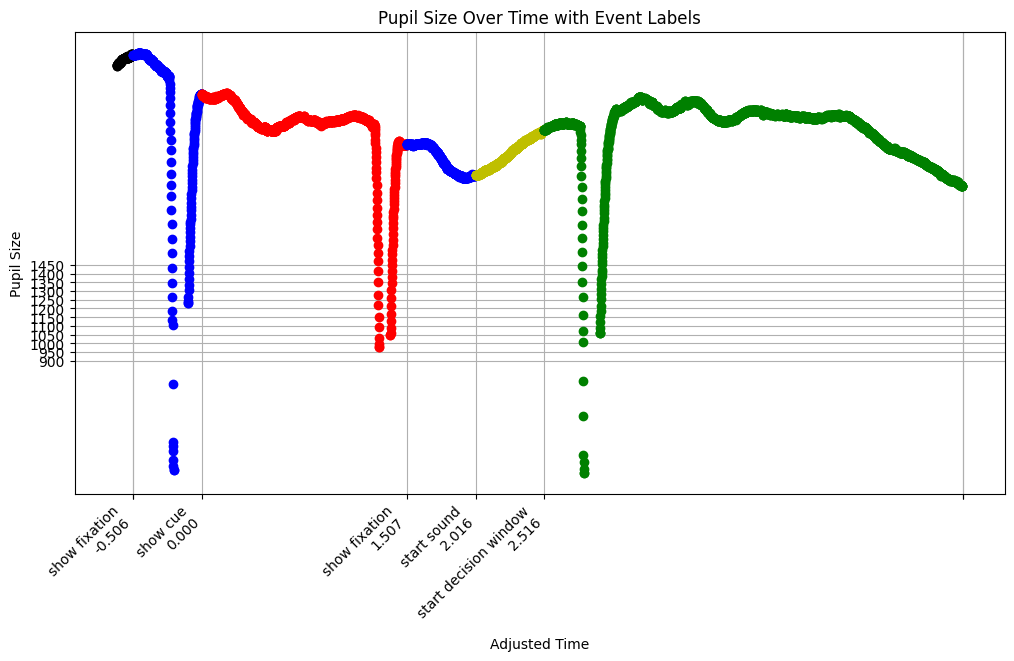

In [8]:
toolkit0912.plot_pupil_size([12], blink_processed= False, normalized= False)

/var/folders/46/761m_1g14d116s883lywtm800000gn/T/ipykernel_2002/1550702412.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_data.loc[:, 'adTimeEvent'] = pupil_data['TimeEvent'] - self.getlog_t_pivot(trial_num) + self.pivot_since_trial_start


[[-174.99999999419487, 524.9999999825845], [0.0, 0.0], [-500.00000001182343, 1500.0000000354703]]


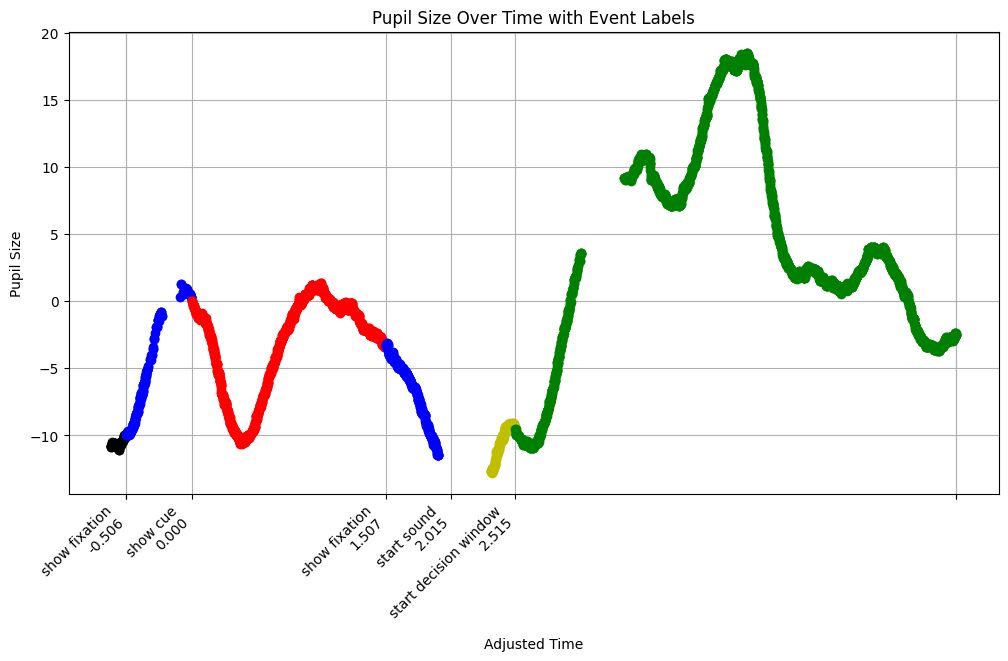

In [6]:
toolkit0912.plot_pupil_size([13])

/var/folders/46/761m_1g14d116s883lywtm800000gn/T/ipykernel_11473/1864646075.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_data.loc[:, 'adTimeEvent'] = pupil_data['TimeEvent'] - self.getlog_t_pivot(trial_num) + self.pivot_since_trial_start


[[-174.99999999419487, 524.9999999825845], [0.0, 0.0], [-500.00000001182343, 1500.0000000354703]]


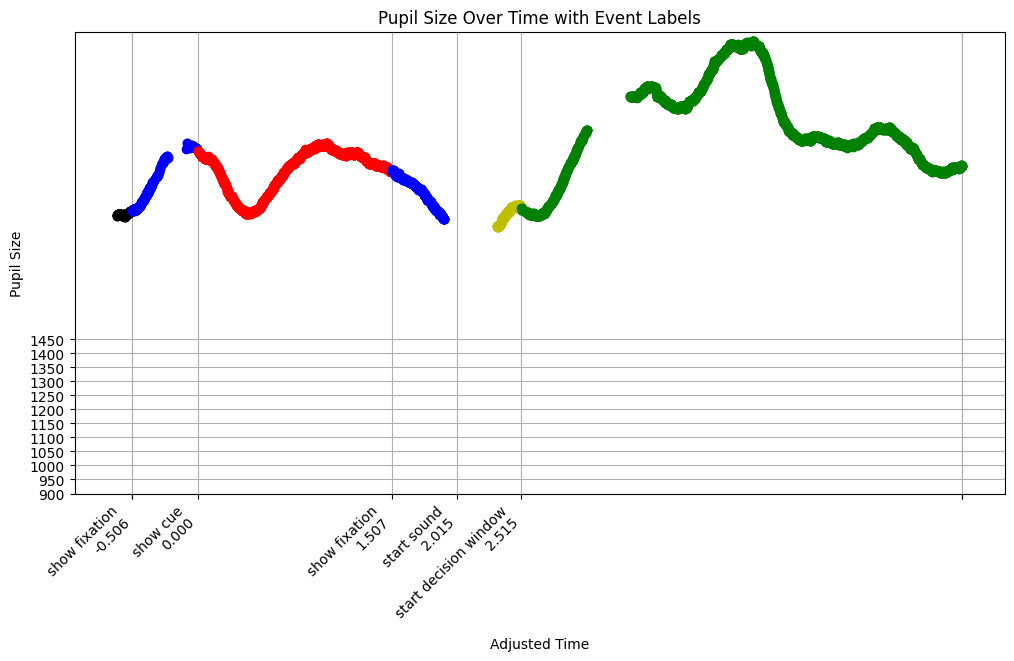

In [40]:
toolkit0912.plot_pupil_size([13], normalized= False)

## 1647


In [ ]:
toolkit1647 = DataAnalyze(exp1647_eye, exp1647_log)

In [ ]:
block1 = [i for i in range(31, 61)]
pplot(block1)

In [ ]:
toolkit1647.log_data.iloc[91]

In [ ]:
toolkit1647.getlog_modified_events_df(8)




In [ ]:
toolkit1647.geteye_pupil_data(9, adjust= True, event='start decision window')

In [ ]:
block1 = [i for i in range(1, 31)]


In [ ]:

plt.figure(figsize=(12, 6))

for trial_index in block1:
    df_events = toolkit1647.getlog_modified_events_df(trial_index)
    df_pupil = toolkit1647.geteye_pupil_data(trial_index, adjust= True)
    for _, row in df_pupil.iterrows():
        if row['event'] == 'show fixation':
            line_color = 'b'
        elif row['event'] == 'show cue':
            line_color = 'r'
        elif row['event'] == 'start decision window':    
            line_color = 'g'
        elif row['event'] == 'start sound':
            line_color = 'y'
        else:
            line_color = 'k'
        plt.plot(row['adTimeEvent'], row['Pupil'], marker='o', color=line_color)

        #plt.hlines(y=row['Pupil'], xmin=row['adStart'], xmax=row['adEnd'], color=line_color, linewidth=2, alpha=0.6)
        
        # plt.text((row['adStart'] + row['adEnd']) / 2, row['Pupil'], row['event'], 
        #               ha='center', va='bottom', fontsize=9)

plt.xticks(df_events['adjusted_time'], 
        labels=[f"{event}\n{time:.3f}" if (event in ['show cue', 'show fixation', 'start sound', 'start decision window']) & (time > (toolkit1647.pivot_since_trial_start-1)) else '' 
                for event, time in zip(df_events['event'], df_events['adjusted_time'])], 
        rotation=45, ha='right')
plt.title('Pupil Size Over Time with Event Labels')
plt.xlabel('Adjusted Time')
plt.ylabel('Pupil Size')
plt.yticks(np.arange(900, 1500, 50))
plt.grid(True)
plt.show()


In [ ]:
block1 = [i for i in range(91, 121)]


plt.figure(figsize=(12, 6))

for trial_index in block1:
    df_events = toolkit1647.getlog_modified_events_df(trial_index)
    df_pupil = toolkit1647.geteye_pupil_data(trial_index, adjust= True)
    for _, row in df_pupil.iterrows():
        if row['event'] == 'show fixation':
            line_color = 'b'
        elif row['event'] == 'show cue':
            line_color = 'r'
        elif row['event'] == 'start decision window':    
            line_color = 'g'
        elif row['event'] == 'start sound':
            line_color = 'y'
        else:
            line_color = 'k'
        plt.plot(row['adTimeEvent'], row['Pupil'], marker='o', color=line_color)

        #plt.hlines(y=row['Pupil'], xmin=row['adStart'], xmax=row['adEnd'], color=line_color, linewidth=2, alpha=0.6)
        
        # plt.text((row['adStart'] + row['adEnd']) / 2, row['Pupil'], row['event'], 
        #               ha='center', va='bottom', fontsize=9)

plt.xticks(df_events['adjusted_time'], 
        labels=[f"{event}\n{time:.3f}" if (event in ['show cue', 'show fixation', 'start sound', 'start decision window']) & (time > (toolkit1647.pivot_since_trial_start-1)) else '' 
                for event, time in zip(df_events['event'], df_events['adjusted_time'])], 
        rotation=45, ha='right')
plt.title('Pupil Size Over Time with Event Labels')
plt.xlabel('Adjusted Time')
plt.ylabel('Pupil Size')
plt.yticks(np.arange(900, 1500, 50))
plt.grid(True)
plt.show()


In [ ]:
def pplot(block1):


    plt.figure(figsize=(12, 6))

    for trial_index in block1:
        df_events = toolkit1647.getlog_modified_events_df(trial_index)
        df_pupil = toolkit1647.geteye_pupil_data(trial_index, adjust= True)
        for _, row in df_pupil.iterrows():
            if row['event'] == 'show fixation':
                line_color = 'b'
            elif row['event'] == 'show cue':
                line_color = 'r'
            elif row['event'] == 'start decision window':    
                line_color = 'g'
            elif row['event'] == 'start sound':
                line_color = 'y'
            else:
                line_color = 'k'
            plt.plot(row['adTimeEvent'], row['Pupil'], marker='o', color=line_color)

            #plt.hlines(y=row['Pupil'], xmin=row['adStart'], xmax=row['adEnd'], color=line_color, linewidth=2, alpha=0.6)
            
            # plt.text((row['adStart'] + row['adEnd']) / 2, row['Pupil'], row['event'], 
            #               ha='center', va='bottom', fontsize=9)

    plt.xticks(df_events['adjusted_time'], 
            labels=[f"{event}\n{time:.3f}" if (event in ['show cue', 'show fixation', 'start sound', 'start decision window']) & (time > (toolkit1647.pivot_since_trial_start-1)) else '' 
                    for event, time in zip(df_events['event'], df_events['adjusted_time'])], 
            rotation=45, ha='right')
    plt.title('Pupil Size Over Time with Event Labels')
    plt.xlabel('Adjusted Time')
    plt.ylabel('Pupil Size')
    plt.yticks(np.arange(900, 1500, 50))
    plt.grid(True)
    plt.show()


## 1606


In [ ]:
toolkit1606.log_data

In [ ]:

exp1606_eye = pd.read_csv('data/processed/v1/eyetracking/24-08-24-1606_setting0.csv')

with open('data/processed/v1/trial_data/24-08-24-1606_setting0.json', 'r') as file:
    exp1606_log = json.load(file)

# Fill NaN values in TimeEvent with corresponding values from Time
#exp1606_eye['TimeEvent'].fillna(exp1606_eye['Time'], inplace=True)




In [ ]:
toolkit1606 = DataAnalyze(exp1606_eye, exp1606_log)

In [ ]:
toolkit1606.eye_data

In [ ]:
toolkit1606.geteye_pupil_data(30, adjust= True)

In [ ]:
# for i in range(1,31):
#     print(toolkit1606.getlog_events_df(i).loc[0])

toolkit1606.getlog_events_df(30)

In [ ]:
toolkit1606.getlog_modified_events_df(30)

In [ ]:
toolkit1606.eye_data[(toolkit1606.eye_data['Type']=='Fixation')&(toolkit1606.eye_data['trial_index']== 30)]

In [ ]:
df_pupil

In [ ]:
block1 = [i for i in range(10, 21)]
block1

In [ ]:
plt.figure(figsize=(12, 6))

for trial_index in block1:
    df_events = toolkit1606.getlog_modified_events_df(trial_index)
    df_pupil = toolkit1606.geteye_pupil_data(trial_index, adjust= True)
    for _, row in df_pupil.iterrows():
        if row['event'] == 'show fixation':
            line_color = 'b'
        elif row['event'] == 'show cue':
            line_color = 'r'
        elif row['event'] == 'start decision window':    
            line_color = 'g'
        elif row['event'] == 'start sound':
            line_color = 'y'
        else:
            line_color = 'k'
        plt.plot(row['adTimeEvent'], row['Pupil'], marker='o', color=line_color)

        #plt.hlines(y=row['Pupil'], xmin=row['adStart'], xmax=row['adEnd'], color=line_color, linewidth=2, alpha=0.6)
        
        # plt.text((row['adStart'] + row['adEnd']) / 2, row['Pupil'], row['event'], 
        #               ha='center', va='bottom', fontsize=9)

plt.xticks(df_events['adjusted_time'], 
        labels=[f"{event}\n{time:.3f}" if (event in ['show cue', 'show fixation', 'start sound', 'start decision window']) & (time > (toolkit1606.pivot_since_trial_start-1)) else '' 
                for event, time in zip(df_events['event'], df_events['adjusted_time'])], 
        rotation=45, ha='right')
plt.title('Pupil Size Over Time with Event Labels')
plt.xlabel('Adjusted Time')
plt.ylabel('Pupil Size')
plt.yticks(np.arange(900, 1500, 50))
plt.grid(True)
plt.show()

In [ ]:
block0 = [i for i in range(1, 11)]
block0

In [ ]:
plt.figure(figsize=(12, 6))

for trial_index in block0:
    df_events = toolkit1606.getlog_modified_events_df(trial_index)
    df_pupil = toolkit1606.geteye_pupil_data(trial_index, adjust= True)
    for _, row in df_pupil.iterrows():
        if row['event'] == 'show fixation':
            line_color = 'b'
        elif row['event'] == 'show cue':
            line_color = 'r'
        elif row['event'] == 'start decision window':    
            line_color = 'g'
        elif row['event'] == 'start sound':
            line_color = 'y'
        else:
            line_color = 'k'
        plt.plot(row['adTimeEvent'], row['Pupil'], marker='o', color=line_color)

        #plt.hlines(y=row['Pupil'], xmin=row['adStart'], xmax=row['adEnd'], color=line_color, linewidth=2, alpha=0.6)
        
        # plt.text((row['adStart'] + row['adEnd']) / 2, row['Pupil'], row['event'], 
        #               ha='center', va='bottom', fontsize=9)

plt.xticks(df_events['adjusted_time'], 
        labels=[f"{event}\n{time:.3f}" if (event in ['show cue', 'show fixation', 'start sound', 'start decision window']) & (time > (toolkit1606.pivot_since_trial_start-1)) else '' 
                for event, time in zip(df_events['event'], df_events['adjusted_time'])], 
        rotation=45, ha='right')
plt.title('Pupil Size Over Time with Event Labels')
plt.xlabel('Adjusted Time')
plt.ylabel('Pupil Size')
plt.yticks(np.arange(900, 1500, 50))
plt.grid(True)
plt.show()

In [ ]:
block = [i for i in range(1, 31)]

plt.figure(figsize=(12, 6))

for trial_index in block0:
    df_events = toolkit1606.getlog_modified_events_df(trial_index)
    df_pupil = toolkit1606.geteye_pupil_data(trial_index, adjust= True)
    for _, row in df_pupil.iterrows():
        if row['event'] == 'show fixation':
            line_color = 'b'
        elif row['event'] == 'show cue':
            line_color = 'r'
        elif row['event'] == 'start decision window':    
            line_color = 'g'
        elif row['event'] == 'start sound':
            line_color = 'y'
        else:
            line_color = 'k'
        plt.plot(row['adTimeEvent'], row['Pupil'], marker='o', color=line_color)

        #plt.hlines(y=row['Pupil'], xmin=row['adStart'], xmax=row['adEnd'], color=line_color, linewidth=2, alpha=0.6)
        
        # plt.text((row['adStart'] + row['adEnd']) / 2, row['Pupil'], row['event'], 
        #               ha='center', va='bottom', fontsize=9)

plt.xticks(df_events['adjusted_time'], 
        labels=[f"{event}\n{time:.3f}" if (event in ['show cue', 'show fixation', 'start sound', 'start decision window']) & (time > (toolkit1606.pivot_since_trial_start-1)) else '' 
                for event, time in zip(df_events['event'], df_events['adjusted_time'])], 
        rotation=45, ha='right')
plt.title('Pupil Size Over Time with Event Labels')
plt.xlabel('Adjusted Time')
plt.ylabel('Pupil Size')
plt.yticks(np.arange(900, 1500, 50))
plt.grid(True)
plt.show()


In [ ]:
bucket = []
for i in range(0,31):
    pupil_Data = toolkit1606.geteye_pupil_data(i, adjust= True)
    for _, row in pupil_Data.iterrows():
        if (row['event'] == 'show fixation') & (3<row['adStart']<4.5):
            bucket.append(row)
        elif (row['event'] == 'show cue') & (row['adStart']< 3):
            bucket.append(row)
        elif (row['event'] == 'start decision window') & (row['adStart']< 5.5):    
            bucket.append(row)
        elif (row['event'] == 'start sound') & ((row['adStart']<5) or (row['adEnd']>5.5)):
            bucket.append(row)


In [ ]:
block100 = [i for i in range(31, 61)]

plt.figure(figsize=(12, 6))

for trial_index in block0:
    df_events = toolkit1606.getlog_modified_events_df(trial_index)
    df_pupil = toolkit1606.geteye_pupil_data(trial_index, adjust= True)
    for _, row in df_pupil.iterrows():
        if row['event'] == 'show fixation':
            line_color = 'b'
        elif row['event'] == 'show cue':
            line_color = 'r'
        elif row['event'] == 'start decision window':    
            line_color = 'g'
        elif row['event'] == 'start sound':
            line_color = 'y'
        else:
            line_color = 'k'
        plt.plot(row['adTimeEvent'], row['Pupil'], marker='o', color=line_color)

        #plt.hlines(y=row['Pupil'], xmin=row['adStart'], xmax=row['adEnd'], color=line_color, linewidth=2, alpha=0.6)
        
        # plt.text((row['adStart'] + row['adEnd']) / 2, row['Pupil'], row['event'], 
        #               ha='center', va='bottom', fontsize=9)

plt.xticks(df_events['adjusted_time'], 
        labels=[f"{event}\n{time:.3f}" if (event in ['show cue', 'show fixation', 'start sound', 'start decision window']) & (time > (toolkit1606.pivot_since_trial_start-1)) else '' 
                for event, time in zip(df_events['event'], df_events['adjusted_time'])], 
        rotation=45, ha='right')
plt.title('Pupil Size Over Time with Event Labels')
plt.xlabel('Adjusted Time')
plt.ylabel('Pupil Size')
plt.yticks(np.arange(900, 1500, 50))
plt.grid(True)
plt.show()
